<a href="https://colab.research.google.com/github/01agrawalamit-sys/Dynamic-Resource-Scheduling-Algorithm/blob/main/Dynamic-Resource-Scheduling-Algorithm%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


DYNAMIC PRIORITY-BASED RESOURCE SCHEDULING ALGORITHM

INPUT DATA
------------------------------------------------------------------------------------------
Tasks: 10
Resources: 3

Task Details:
  T1: Priority=10, Duration=5.0
  T2: Priority=5, Duration=3.0
  T3: Priority=8, Duration=8.0
  T4: Priority=3, Duration=2.0
  T5: Priority=7, Duration=6.0
  T6: Priority=9, Duration=4.0
  T7: Priority=4, Duration=7.0
  T8: Priority=6, Duration=3.5
  T9: Priority=8, Duration=5.5
  T10: Priority=10, Duration=2.5


Starting scheduling process...
Total tasks: 10, Total resources: 3
Weights - Priority: 1.0, Duration: 0.5

Scheduling complete! 10 tasks scheduled.

DYNAMIC PRIORITY-BASED RESOURCE SCHEDULE
Task ID      Resource     Priority   Duration   Start      End       
------------------------------------------------------------------------------------------
T10          R1           10         2.50       0.00       2.50      
T1           R2           10         5.00       0.00       5.00      

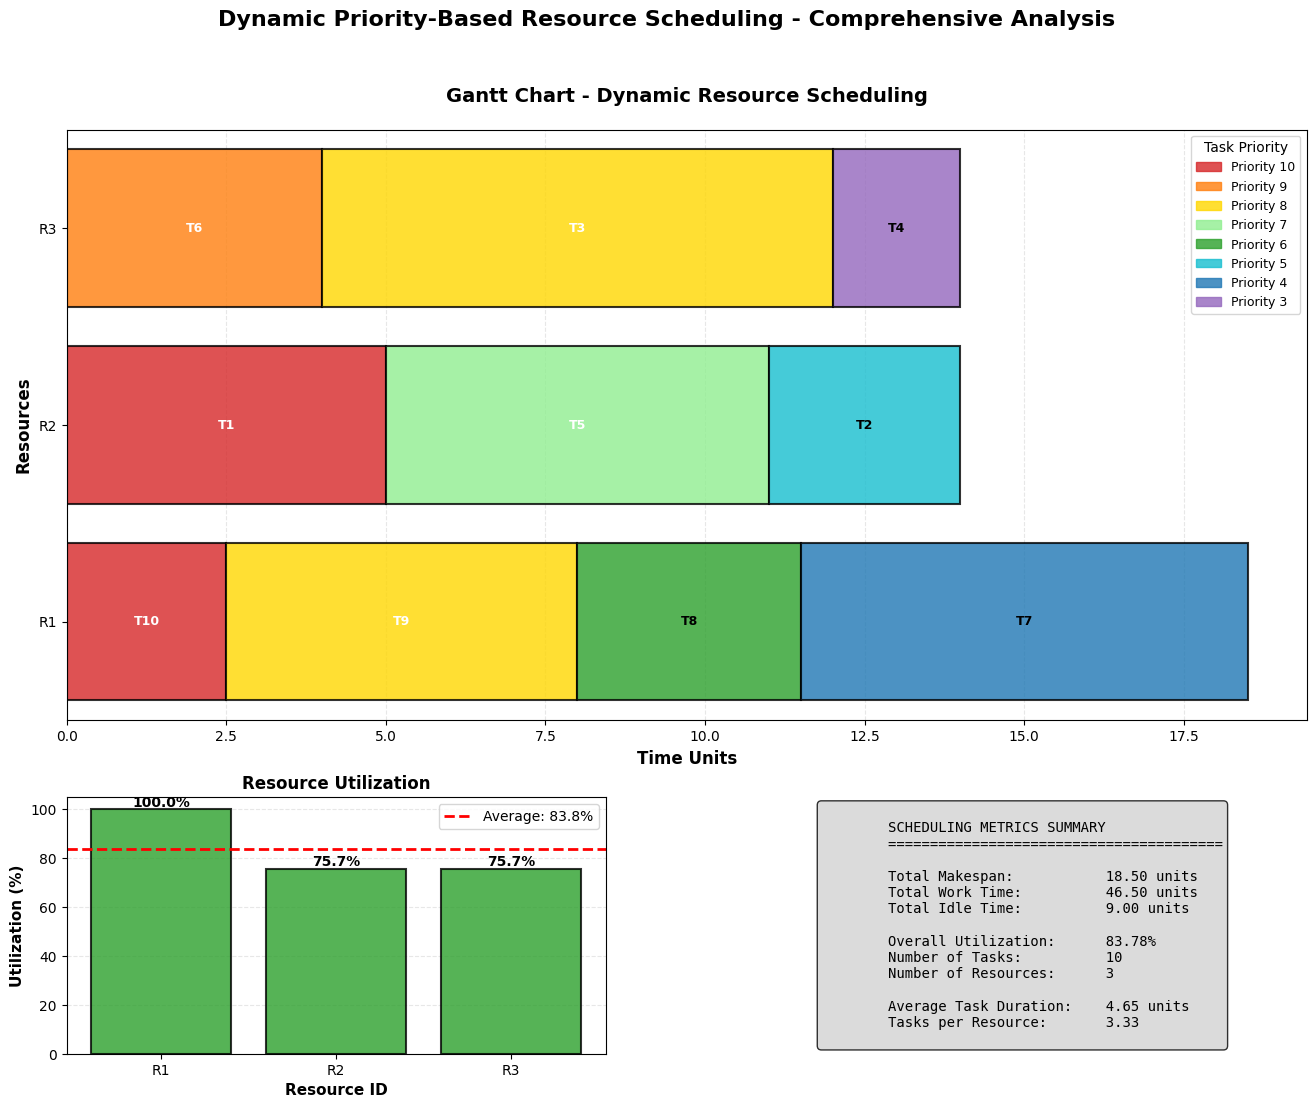


ALGORITHM EXPLANATION
------------------------------------------------------------------------------------------
This scheduler uses a dynamic scoring mechanism that balances:
1. Task Priority: Higher priority tasks are favored
2. Task Duration: Shorter tasks receive bonus points (inverse duration)

The algorithm continuously adapts by recalculating scores after each
assignment, allowing it to respond to changing resource availability.
This results in efficient resource utilization and minimal idle time.



In [2]:
import heapq
from dataclasses import dataclass, field
from typing import List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import numpy as np


@dataclass
class Task:
    """Represents a task to be scheduled."""
    task_id: str
    duration: float
    priority: int
    score: float = 0.0

    def __post_init__(self):
        if self.duration <= 0:
            raise ValueError(f"Task {self.task_id}: duration must be positive")
        if self.priority < 0:
            raise ValueError(f"Task {self.task_id}: priority cannot be negative")

    def calculate_score(self, priority_weight: float, duration_weight: float) -> float:
        """
        Calculate dynamic score for task prioritization.
        Higher score = higher priority in scheduling.
        """
        self.score = (priority_weight * self.priority) + (duration_weight * (1 / self.duration))
        return self.score


@dataclass
class Resource:
    """Represents a resource that can execute tasks."""
    resource_id: str
    availability_time: float = 0.0

    def __lt__(self, other):
        """Enable comparison for heap operations based on availability time."""
        return self.availability_time < other.availability_time


@dataclass
class ScheduledTask:
    """Represents a scheduled task assignment."""
    task_id: str
    resource_id: str
    start_time: float
    end_time: float
    priority: int
    duration: float


class DynamicPriorityScheduler:
    """
    Dynamic Priority-Based Resource Scheduler with Visualization.

    Implements a heuristic approach that dynamically adjusts task priorities
    based on both task importance and duration to maximize resource utilization.
    """

    def __init__(self, priority_weight: float = 1.0, duration_weight: float = 0.5):
        """
        Initialize scheduler with configurable weights.

        Args:
            priority_weight: Weight for task priority in scoring (default: 1.0)
            duration_weight: Weight for inverse duration in scoring (default: 0.5)
        """
        self.priority_weight = priority_weight
        self.duration_weight = duration_weight
        self.schedule: List[ScheduledTask] = []
        self.resource_idle_times: defaultdict = defaultdict(float)

    def validate_inputs(self, tasks: List[Task], resources: List[Resource]) -> None:
        """Validate task and resource inputs."""
        if not tasks:
            raise ValueError("Task list cannot be empty")
        if not resources:
            raise ValueError("Resource list cannot be empty")

        # Check for duplicate task IDs
        task_ids = [task.task_id for task in tasks]
        if len(task_ids) != len(set(task_ids)):
            raise ValueError("Duplicate task IDs found")

        # Check for duplicate resource IDs
        resource_ids = [resource.resource_id for resource in resources]
        if len(resource_ids) != len(set(resource_ids)):
            raise ValueError("Duplicate resource IDs found")

    def build_task_priority_queue(self, tasks: List[Task]) -> List[Tuple[float, int, Task]]:
        """
        Build a max-priority queue of tasks based on dynamic scores.

        Uses negative scores to simulate max-heap with Python's min-heap.
        Includes a counter to break ties and maintain stable ordering.

        Returns:
            List of tuples: (-score, counter, task)
        """
        priority_queue = []
        for idx, task in enumerate(tasks):
            task.calculate_score(self.priority_weight, self.duration_weight)
            # Use negative score for max-heap behavior
            # Include idx to ensure stable ordering when scores are equal
            heapq.heappush(priority_queue, (-task.score, idx, task))
        return priority_queue

    def get_earliest_available_resource(self, resources: List[Resource]) -> Resource:
        """
        Find the resource with the earliest availability time.

        Returns:
            Resource object with minimum availability_time
        """
        return min(resources, key=lambda r: r.availability_time)

    def assign_task(self, task: Task, resource: Resource) -> ScheduledTask:
        """
        Assign a task to a resource and update resource availability.

        Args:
            task: Task to be scheduled
            resource: Resource to execute the task

        Returns:
            ScheduledTask object representing the assignment
        """
        start_time = resource.availability_time
        end_time = start_time + task.duration

        # Create scheduled task record
        scheduled_task = ScheduledTask(
            task_id=task.task_id,
            resource_id=resource.resource_id,
            start_time=start_time,
            end_time=end_time,
            priority=task.priority,
            duration=task.duration
        )

        # Update resource availability
        resource.availability_time = end_time

        return scheduled_task

    def schedule_tasks(self, tasks: List[Task], resources: List[Resource]) -> List[ScheduledTask]:
        """
        Main scheduling algorithm with dynamic priority adjustment.

        Algorithm Steps:
        1. Validate inputs
        2. Create initial priority queue based on dynamic scores
        3. Iteratively:
           - Select earliest available resource
           - Pop highest-scoring task from queue
           - Assign task to resource
           - Recalculate scores for remaining tasks
           - Rebuild priority queue
        4. Continue until all tasks scheduled

        Args:
            tasks: List of Task objects to schedule
            resources: List of Resource objects available

        Returns:
            List of ScheduledTask objects representing the complete schedule
        """
        # Step 1: Validate inputs
        self.validate_inputs(tasks, resources)

        # Initialize schedule and remaining tasks
        self.schedule = []
        remaining_tasks = tasks.copy()

        # Step 2: Build initial priority queue
        task_queue = self.build_task_priority_queue(remaining_tasks)

        print(f"Starting scheduling process...")
        print(f"Total tasks: {len(tasks)}, Total resources: {len(resources)}")
        print(f"Weights - Priority: {self.priority_weight}, Duration: {self.duration_weight}\n")

        # Step 3: Schedule tasks iteratively
        while task_queue:
            # Step 4a: Get earliest available resource
            selected_resource = self.get_earliest_available_resource(resources)

            # Step 4b: Pop highest-scoring task (max-heap via negative scores)
            neg_score, _, selected_task = heapq.heappop(task_queue)

            # Step 4c: Assign task to resource
            scheduled_task = self.assign_task(selected_task, selected_resource)
            self.schedule.append(scheduled_task)

            # Remove scheduled task from remaining tasks
            remaining_tasks.remove(selected_task)

            # Step 5: Recalculate scores and rebuild queue for remaining tasks
            if remaining_tasks:
                task_queue = self.build_task_priority_queue(remaining_tasks)

        print(f"Scheduling complete! {len(self.schedule)} tasks scheduled.\n")
        return self.schedule

    def calculate_metrics(self, resources: List[Resource]) -> dict:
        """
        Calculate scheduling performance metrics.

        Metrics:
        - Makespan: Total time from start to completion of all tasks
        - Resource Utilization: Percentage of time resources are actively working
        - Idle Time: Time each resource spends waiting

        Returns:
            Dictionary containing all calculated metrics
        """
        if not self.schedule:
            return {
                'makespan': 0,
                'total_work_time': 0,
                'total_idle_time': 0,
                'resource_utilization': 0.0,
                'idle_times': {}
            }

        # Calculate makespan (maximum end time across all tasks)
        makespan = max(task.end_time for task in self.schedule)

        # Calculate total work time (sum of all task durations)
        total_work_time = sum(task.duration for task in self.schedule)

        # Calculate idle time per resource
        idle_times = {}
        for resource in resources:
            # Idle time = makespan - actual work time on this resource
            work_time = sum(
                task.duration for task in self.schedule
                if task.resource_id == resource.resource_id
            )
            idle_times[resource.resource_id] = makespan - work_time

        total_idle_time = sum(idle_times.values())

        # Calculate resource utilization percentage
        total_available_time = makespan * len(resources)
        resource_utilization = (total_work_time / total_available_time * 100) if total_available_time > 0 else 0

        return {
            'makespan': makespan,
            'total_work_time': total_work_time,
            'total_idle_time': total_idle_time,
            'resource_utilization': resource_utilization,
            'idle_times': idle_times
        }

    def print_schedule(self, resources: List[Resource]) -> None:
        """
        Print the complete schedule in a formatted table with metrics.
        """
        if not self.schedule:
            print("No tasks scheduled.")
            return

        # Sort schedule by start time for better readability
        sorted_schedule = sorted(self.schedule, key=lambda x: x.start_time)

        # Print header
        print("=" * 90)
        print("DYNAMIC PRIORITY-BASED RESOURCE SCHEDULE")
        print("=" * 90)
        print(f"{'Task ID':<12} {'Resource':<12} {'Priority':<10} {'Duration':<10} {'Start':<10} {'End':<10}")
        print("-" * 90)

        # Print each scheduled task
        for task in sorted_schedule:
            print(f"{task.task_id:<12} {task.resource_id:<12} {task.priority:<10} "
                  f"{task.duration:<10.2f} {task.start_time:<10.2f} {task.end_time:<10.2f}")

        print("=" * 90)

        # Calculate and print metrics
        metrics = self.calculate_metrics(resources)

        print("\nSCHEDULING METRICS")
        print("-" * 90)
        print(f"Total Makespan:          {metrics['makespan']:.2f} time units")
        print(f"Total Work Time:         {metrics['total_work_time']:.2f} time units")
        print(f"Total Idle Time:         {metrics['total_idle_time']:.2f} time units")
        print(f"Resource Utilization:    {metrics['resource_utilization']:.2f}%")

        print("\nIDLE TIME PER RESOURCE")
        print("-" * 90)
        for resource_id, idle_time in sorted(metrics['idle_times'].items()):
            work_time = metrics['makespan'] - idle_time
            utilization = (work_time / metrics['makespan'] * 100) if metrics['makespan'] > 0 else 0
            print(f"{resource_id:<12} - Idle: {idle_time:>8.2f} time units  "
                  f"(Utilization: {utilization:.2f}%)")

        print("=" * 90)

    def visualize_schedule(self, resources: List[Resource], save_path: str = None):
        """
        Create comprehensive visualizations of the schedule.

        Generates:
        1. Gantt Chart showing task assignments over time
        2. Resource Utilization Bar Chart
        3. Task Priority Distribution
        4. Timeline visualization
        """
        if not self.schedule:
            print("No schedule to visualize.")
            return

        metrics = self.calculate_metrics(resources)

        # Create figure with subplots
        fig = plt.figure(figsize=(16, 12))
        gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

        # ===== 1. GANTT CHART =====
        ax1 = fig.add_subplot(gs[0:2, :])

        # Define colors for different priority levels
        priority_colors = {
            10: '#d62728',  # Red - Highest
            9: '#ff7f0e',   # Orange
            8: '#ffd700',   # Gold
            7: '#90ee90',   # Light Green
            6: '#2ca02c',   # Green
            5: '#17becf',   # Cyan
            4: '#1f77b4',   # Blue
            3: '#9467bd',   # Purple
            2: '#8c564b',   # Brown
            1: '#7f7f7f',   # Gray - Lowest
        }

        # Get unique resources and create y-axis mapping
        resource_ids = sorted(list(set(task.resource_id for task in self.schedule)))
        resource_to_y = {rid: idx for idx, rid in enumerate(resource_ids)}

        # Plot each task as a horizontal bar
        for task in self.schedule:
            y_pos = resource_to_y[task.resource_id]
            color = priority_colors.get(task.priority, '#bcbd22')

            # Create rectangle for task
            rect = Rectangle(
                (task.start_time, y_pos - 0.4),
                task.duration,
                0.8,
                facecolor=color,
                edgecolor='black',
                linewidth=1.5,
                alpha=0.8
            )
            ax1.add_patch(rect)

            # Add task label
            ax1.text(
                task.start_time + task.duration / 2,
                y_pos,
                task.task_id,
                ha='center',
                va='center',
                fontsize=9,
                fontweight='bold',
                color='white' if task.priority >= 7 else 'black'
            )

        # Configure Gantt chart
        ax1.set_ylim(-0.5, len(resource_ids) - 0.5)
        ax1.set_xlim(0, metrics['makespan'] * 1.05)
        ax1.set_yticks(range(len(resource_ids)))
        ax1.set_yticklabels(resource_ids)
        ax1.set_xlabel('Time Units', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Resources', fontsize=12, fontweight='bold')
        ax1.set_title('Gantt Chart - Dynamic Resource Scheduling',
                      fontsize=14, fontweight='bold', pad=20)
        ax1.grid(True, axis='x', alpha=0.3, linestyle='--')
        ax1.set_axisbelow(True)

        # Add legend for priorities
        legend_elements = [
            mpatches.Patch(color=priority_colors.get(p, '#bcbd22'),
                          label=f'Priority {p}', alpha=0.8)
            for p in sorted(set(task.priority for task in self.schedule), reverse=True)
        ]
        ax1.legend(handles=legend_elements, loc='upper right',
                  fontsize=9, title='Task Priority')

        # ===== 2. RESOURCE UTILIZATION BAR CHART =====
        ax2 = fig.add_subplot(gs[2, 0])

        resource_utilizations = []
        for resource_id in resource_ids:
            work_time = sum(
                task.duration for task in self.schedule
                if task.resource_id == resource_id
            )
            utilization = (work_time / metrics['makespan'] * 100) if metrics['makespan'] > 0 else 0
            resource_utilizations.append(utilization)

        bars = ax2.bar(resource_ids, resource_utilizations,
                       color=['#2ca02c' if u >= 70 else '#ff7f0e' if u >= 50 else '#d62728'
                              for u in resource_utilizations],
                       edgecolor='black', linewidth=1.5, alpha=0.8)

        # Add value labels on bars
        for bar, util in zip(bars, resource_utilizations):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{util:.1f}%',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

        ax2.set_xlabel('Resource ID', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Utilization (%)', fontsize=11, fontweight='bold')
        ax2.set_title('Resource Utilization', fontsize=12, fontweight='bold')
        ax2.set_ylim(0, 105)
        ax2.grid(True, axis='y', alpha=0.3, linestyle='--')
        ax2.set_axisbelow(True)

        # Add average line
        avg_util = np.mean(resource_utilizations)
        ax2.axhline(y=avg_util, color='red', linestyle='--',
                   linewidth=2, label=f'Average: {avg_util:.1f}%')
        ax2.legend()

        # ===== 3. METRICS SUMMARY =====
        ax3 = fig.add_subplot(gs[2, 1])
        ax3.axis('off')

        # Create metrics text
        metrics_text = f"""
        SCHEDULING METRICS SUMMARY
        {'='*40}

        Total Makespan:           {metrics['makespan']:.2f} units
        Total Work Time:          {metrics['total_work_time']:.2f} units
        Total Idle Time:          {metrics['total_idle_time']:.2f} units

        Overall Utilization:      {metrics['resource_utilization']:.2f}%
        Number of Tasks:          {len(self.schedule)}
        Number of Resources:      {len(resource_ids)}

        Average Task Duration:    {metrics['total_work_time']/len(self.schedule):.2f} units
        Tasks per Resource:       {len(self.schedule)/len(resource_ids):.2f}
        """

        ax3.text(0.1, 0.5, metrics_text,
                fontsize=10, family='monospace',
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

        # Main title for the entire figure
        fig.suptitle('Dynamic Priority-Based Resource Scheduling - Comprehensive Analysis',
                     fontsize=16, fontweight='bold', y=0.98)

        # Save or show
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"\nVisualization saved to: {save_path}")
        else:
            plt.savefig('schedule_visualization.png', dpi=300, bbox_inches='tight')
            print(f"\nVisualization saved to: schedule_visualization.png")

        plt.show()


def main():
    """
    Main function demonstrating the Dynamic Priority Scheduler with Visualizations.
    """
    print("\n" + "="*90)
    print("DYNAMIC PRIORITY-BASED RESOURCE SCHEDULING ALGORITHM")
    print("="*90 + "\n")

    # Create sample tasks with varying priorities and durations
    tasks = [
        Task(task_id="T1", duration=5.0, priority=10),   # High priority, medium duration
        Task(task_id="T2", duration=3.0, priority=5),    # Medium priority, short duration
        Task(task_id="T3", duration=8.0, priority=8),    # High priority, long duration
        Task(task_id="T4", duration=2.0, priority=3),    # Low priority, short duration
        Task(task_id="T5", duration=6.0, priority=7),    # Medium-high priority, medium duration
        Task(task_id="T6", duration=4.0, priority=9),    # High priority, short-medium duration
        Task(task_id="T7", duration=7.0, priority=4),    # Low-medium priority, medium-long duration
        Task(task_id="T8", duration=3.5, priority=6),    # Medium priority, short-medium duration
        Task(task_id="T9", duration=5.5, priority=8),    # High priority, medium duration
        Task(task_id="T10", duration=2.5, priority=10),  # High priority, short duration
    ]

    # Create resources
    resources = [
        Resource(resource_id="R1"),
        Resource(resource_id="R2"),
        Resource(resource_id="R3"),
    ]

    print("INPUT DATA")
    print("-" * 90)
    print(f"Tasks: {len(tasks)}")
    print(f"Resources: {len(resources)}")
    print("\nTask Details:")
    for task in tasks:
        print(f"  {task.task_id}: Priority={task.priority}, Duration={task.duration}")
    print("\n")

    # Initialize scheduler with custom weights
    scheduler = DynamicPriorityScheduler(priority_weight=1.0, duration_weight=0.5)

    # Execute scheduling
    schedule = scheduler.schedule_tasks(tasks, resources)

    # Print results
    scheduler.print_schedule(resources)

    # Generate visualizations
    print("\nGenerating visualizations...")
    scheduler.visualize_schedule(resources, save_path='dynamic_schedule_analysis.png')

    print("\nALGORITHM EXPLANATION")
    print("-" * 90)
    print("This scheduler uses a dynamic scoring mechanism that balances:")
    print("1. Task Priority: Higher priority tasks are favored")
    print("2. Task Duration: Shorter tasks receive bonus points (inverse duration)")
    print("\nThe algorithm continuously adapts by recalculating scores after each")
    print("assignment, allowing it to respond to changing resource availability.")
    print("This results in efficient resource utilization and minimal idle time.")
    print("="*90 + "\n")


if __name__ == "__main__":
    main()